In [1]:
import tifffile as tiff
import pandas as pd
import os
from matplotlib import pyplot as plt
import gc
import rasterio
import numpy as np
from model import utils
from model import datagen
import cv2
from glob import glob
import tensorflow as tf
import time

In [31]:
train_raw_df = pd.read_csv(utils.TRAIN_PATH).set_index('id')
train_raw_df = train_raw_df
train_raw_df.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [8]:
def parse_size(s):
    n = float(s[:-1])
    if s[-1] == 'G':
        n *= 1000
    return int(n)

parse_size('110M')

110

In [32]:
def parse_sizes(filename: str):
    sizes_df = pd.read_csv(filename, sep='\t')
    sizes_df['id'] = sizes_df['id'].apply(lambda s: s.split('.')[0])
    sizes_df['size'] = sizes_df['size'].apply(parse_size)
    sizes_df['glom'] = sizes_df['id'].apply(lambda s: int('glom' in s))
    sizes_df['num_records'] = sizes_df['id'].apply(lambda s: int(s.split('-')[-1]))
    sizes_df['id'] = sizes_df['id'].apply(lambda s: s.split('-')[0])
    sizes_df['num_glom_records'] = sizes_df['num_records'] * sizes_df['glom']
    sizes_df['num_records'] = sizes_df['num_records'] * (1 - sizes_df['glom'])
    sizes_df.drop(['glom'], axis='columns', inplace=True)
    sizes_df = sizes_df.groupby('id').sum()
    return sizes_df

parse_sizes('sizes.tsv').head()

,size,num_records,num_glom_records
id,,,
0486052bb,1615,1933,473
095bf7a1f,2630,3093,1474
1e2425f28,2438,3138,830
26dc41664,3135,4428,1041
2f6ecfcdf,1449,1687,512


In [57]:
train_df = pd.concat([train_raw_df, parse_sizes('sizes.tsv')], axis=1)
train_df = train_df.sort_values(by='size')
train_df.to_csv(utils.TRAIN_PATH)

In [58]:
del train_raw_df
del train_df
gc.collect()

333885

In [63]:
train_df = pd.read_csv(utils.TRAIN_PATH).set_index('id')
train_df.head()

,encoding,size,num_records,num_glom_records
id,,,,
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...,548,579,290
b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...,889,1008,401
54f2eec69,124967057 36 124997425 109 125027828 147 12505...,1150,1434,589
e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...,1274,1409,745
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...,1449,1687,512


In [67]:
print(train_df['size'][:10].sum())
print(train_df['size'][10:12].sum())
print(train_df['size'][12:].sum())

17725
6775
12609


In [66]:
train_ids = list(train_df.index[:10])
valid_ids = list(train_df.index[10:12])
tests_ids = list(train_df.index[12:])

In [65]:
tests_df = train_df.loc[tests_ids]
tests_df

,encoding,size,num_records,num_glom_records
id,,,,
c68fe75ea,21256809 3 21283644 10 21310479 17 21337315 22...,4023,7151,569
4ef6695ce,137041956 58 137081912 65 137121869 72 1371618...,5100,6459,1926


In [22]:
tiff_name = '1e2425f28'
tiff_path = os.path.join(utils.TRAIN_DIR, f'{tiff_name}.tiff')
tiff_path

'/data/kaggle/hubmap/train/1e2425f28.tiff'

In [4]:
encoding = train_df.loc[tiff_name].values[0]
print(len(encoding.split()) // 2)

136526


In [5]:
with rasterio.open(tiff_path, transform=rasterio.Affine(1, 0, 0, 0, 1, 0)) as tiff_reader:
    shape = tiff_reader.shape
shape

/home/nishaq/Documents/kaggle/.kaggle/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(26780, 32220)

In [6]:
tile_gen = datagen.tiff_tile_generator(
    tiff_path=tiff_path,
    encoding=encoding,
    tile_size=512,
    min_overlap=128,
)
count = 0
full_mask = np.zeros(shape, dtype=np.uint8)
glom_tile = np.zeros(shape, dtype=np.uint8)
glom_mask = np.zeros(shape, dtype=np.uint8)
for _, mask, x1, x2, y1, y2 in tile_gen:
    count += 1
    if count % 100 == 0:
        print(f'{count:4d}', end=' ' if count % 1000 != 0 else '\n')
    full_mask[x1:x2, y1:y2] = 1
    if mask.sum() > 0:
        glom_tile[x1:x2, y1:y2] = 1
    glom_mask[x1:x2, y1:y2] = mask
print(f'{count:4d}')

num_slices: 5880
 100  200  300  400  500  600  700  800  900 1000
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000
2100 2200 2300 2400 2500 2600 2700 2800 2900 3000
3100 3200 3300 3400 3500 3600 3700 3800 3900 3968


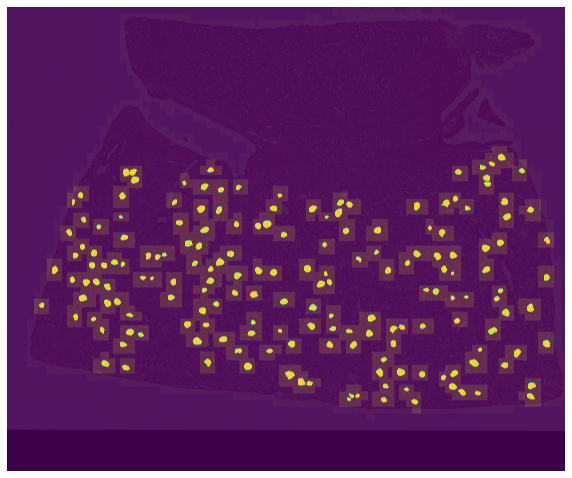

In [7]:
image = tiff.imread(tiff_path)
plt.figure(figsize=(10, 10))

if image.shape[0] == 3:
    plt.imshow(np.moveaxis(image, 0, -1))
else:
    plt.imshow(image)
plt.imshow(full_mask, alpha=0.25)
plt.imshow(glom_tile, alpha=0.50)
plt.imshow(glom_mask, alpha=0.75)
plt.axis('off')
plt.show()

In [9]:
print(f'image: {image.shape}')
print(f'full_mask: {full_mask.shape}')
print(f'glom_mask: {glom_mask.shape}')

image: (3, 26780, 32220)
full_mask: (26780, 32220)
glom_mask: (26780, 32220)


In [10]:
del image
del full_mask
del glom_tile
del glom_mask
gc.collect()

3505

In [52]:
train_filenames = [os.path.join(utils.TF_TRAIN_DIR, f) for f in train_ids]
valid_filenames = [os.path.join(utils.TF_TRAIN_DIR, f) for f in valid_ids]
tests_filenames = [os.path.join(utils.TF_TRAIN_DIR, f) for f in tests_ids]

_ = list(map(print, train_filenames))

# train_filepaths = [f for f in filenames if get_id(f) in train_filenames]
# train_filepaths = list(sorted(train_filepaths))

# train_glom_filepaths = [f for f in glom_filenames if get_id(f) in train_filenames]
# train_glom_filepaths = list(sorted(train_glom_filepaths))

# valid_filepaths = [f for f in filenames if get_id(f) in valid_filenames]
# valid_filepaths = list(sorted(valid_filepaths))

# valid_glom_filepaths = [f for f in glom_filenames if get_id(f) in valid_filenames]
# valid_glom_filepaths = list(sorted(valid_glom_filepaths))

# tests_filepaths = [f for f in filenames if get_id(f) in tests_filenames]
# tests_filepaths = list(sorted(tests_filepaths))

# tests_glom_filepaths = [f for f in glom_filenames if get_id(f) in tests_filenames]
# tests_glom_filepaths = list(sorted(tests_glom_filepaths))

# print('train:')
# _ = [print(f'{f1}\n{f2}\n') for f1, f2 in zip(train_filepaths, train_glom_filepaths)]
# print('valid:')
# _ = [print(f'{f1}\n{f2}\n') for f1, f2 in zip(valid_filepaths, valid_glom_filepaths)]
# print('tests:')
# _ = [print(f'{f1}\n{f2}\n') for f1, f2 in zip(tests_filepaths, tests_glom_filepaths)]

/data/kaggle/hubmap/tf_train/aaa6a05cc
/data/kaggle/hubmap/tf_train/b2dc8411c
/data/kaggle/hubmap/tf_train/54f2eec69
/data/kaggle/hubmap/tf_train/e79de561c
/data/kaggle/hubmap/tf_train/2f6ecfcdf
/data/kaggle/hubmap/tf_train/0486052bb
/data/kaggle/hubmap/tf_train/1e2425f28
/data/kaggle/hubmap/tf_train/afa5e8098
/data/kaggle/hubmap/tf_train/095bf7a1f
/data/kaggle/hubmap/tf_train/26dc41664


In [58]:
train_records = [int(f.split('-')[-1].split('.')[0]) for f in train_filepaths]
num_train_records = sum(train_records)

train_glom_records = [int(f.split('-')[-1].split('.')[0]) for f in train_glom_filepaths]
num_train_glom_records = sum(train_glom_records)

steps_per_epoch = 1 + num_train_records // 16

print(num_train_records, num_train_glom_records)
print(steps_per_epoch)

45108 11932
2820


In [59]:
valid_records = [int(f.split('-')[-1].split('.')[0]) for f in valid_filepaths]
num_valid_records = sum(valid_records)

valid_glom_records = [int(f.split('-')[-1].split('.')[0]) for f in valid_glom_filepaths]
num_valid_glom_records = sum(valid_glom_records)

valid_steps = 1 + num_valid_records // 16

print(num_valid_records, num_valid_glom_records)
print(valid_steps)

4530 1846
284


In [61]:
tests_records = [int(f.split('-')[-1].split('.')[0]) for f in tests_filepaths]
num_tests_records = sum(tests_records)

tests_glom_records = [int(f.split('-')[-1].split('.')[0]) for f in tests_glom_filepaths]
num_tests_glom_records = sum(tests_glom_records)

tests_steps = 1 + num_tests_records // 16

print(num_tests_records, num_tests_glom_records)
print(tests_steps)

1587 691
100


In [30]:
tfrec_dataset = datagen.load_tfrecords(filenames, tile_size=512)
tfrec_dataset = tfrec_dataset.repeat()
tfrec_dataset = tfrec_dataset.shuffle(42)
tfrec_dataset = tfrec_dataset.batch(16)
tfrec_dataset = iter(tfrec_dataset)

tfrec_glom_dataset = datagen.load_tfrecords(glom_filenames, tile_size=512)
tfrec_glom_dataset = tfrec_glom_dataset.repeat()
tfrec_glom_dataset = tfrec_glom_dataset.shuffle(42)
tfrec_glom_dataset = tfrec_glom_dataset.batch(16)
tfrec_glom_dataset = iter(tfrec_glom_dataset)

# val1 = next(tfrec_dataset)
# val2 = next(tfrec_glom_dataset)

In [31]:
start = time.time()
count = 0
for val1, val2 in zip(tfrec_dataset, tfrec_glom_dataset):
    images1, masks1, indices1 = val1
    images2, masks2, indices2 = val2
    images = tf.concat([images1, images2], axis=0)
    masks = tf.concat([masks1, masks2], axis=0)
    indices = tf.concat([indices1, indices2], axis=0)
    count += 1
    if count % 100 == 0:
        print(images.numpy().shape, masks.numpy().shape, indices.numpy().shape)
        print(f'{count:4d}, {time.time() - start:.2f}')
print(f'{count:4d}, {time.time() - start:.2f}')

(32, 512, 512, 3) (32, 512, 512) (32, 4)
 100, 10.77
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 200, 20.79
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 300, 31.21
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 400, 41.42
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 500, 52.07
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 600, 62.38
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 700, 72.79
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 800, 83.36
(32, 512, 512, 3) (32, 512, 512) (32, 4)
 900, 94.00
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1000, 104.33
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1100, 114.90
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1200, 125.63
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1300, 136.42
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1400, 146.78
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1500, 157.20
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1600, 167.44
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1700, 177.49
(32, 512, 512, 3) (32, 512, 512) (32, 4)
1800, 187.34
(32, 512, 512, 3) (32, 512, 512) (32,

KeyboardInterrupt: 